<a href="https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting the $B_c^+ \to J/\psi \mu^+ \nu_\mu$ RapidSim MC angular distribution

In this notebook, we perform a 3D fit to the anglular distribution of the $B_c^+ \to J/\psi \mu^+ \nu_\mu$ decay. Our goal is to measure the helicity amplitudes which parameterise the decay. The angular distribution is defined in [this paper](https://arxiv.org/pdf/2007.06956.pdf) Table I. The values of the helicity parameters we measure will correspond to those used to generate the $B_c^+ \to J/\psi \mu^+ \nu_\mu$ RapidSim MC. In real life, we would want to measure these parameters in real data, to understand the underlying physics of the decay.

## The helicity amplitudes 

The helicity amplitudes $H$ are complex numbers with a magnitude and a phase each. By convention, we have:
 - Three helicity amplitudes called $H_0$, $H_+$, and $H_-$.
 - These helicity amplitudes have magnitudes $|H_0|$, $|H_+|$, and $|H_-|$. They are related by the expression $|H_0|^2 + |H_-|^2 + |H_+|^2 = 1$, which means we only need to measure two of these magnitudes in order to know all three.
 - Each helicity amplitude also has a phase, so we have $\phi_0$, $\phi_+$, and $\phi_-$. One of these is not physically meaningful, as only relative phases are observable. So in practice we set $\phi_0 = 0$, and then measure $\phi_+$ and $\phi_-$ relative to this. In practice, non-zero values for these phases represent interference between the $H_{+/-}$ helicity amplitudes and the $H_0$ one. 

In [1]:
#Install required packages
!pip install uproot
!pip install tensorflow==2.6.0 #specific version for compatability with zfit
!pip install zfit
!pip install uncertainties

In [2]:
import tensorflow as tf
tf.__version__ #specific version we need for zfit to behave

'2.6.0'

In [3]:
#Import other useful packages
import uproot
import random
import json
import zfit
from uncertainties import *
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


## Load RapidSim MC

Let's load our ROOT file containing the true decay angles, calculated in the [Bc2JpsiMuNu_RapidSim.ipynb](https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim.ipynb) notebook.

In [4]:
#Load ROOT file containing true decay angles
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files"
file_path = f"{drive_dir}/Bc2JpsiMuNu_RapidSim_Vars"
print(f"Loading ROOT file {file_path}.root")
tree_name = "DecayTree"
events = uproot.open(f"{file_path}.root:{tree_name}")
events

Loading ROOT file /content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files/Bc2JpsiMuNu_RapidSim_Vars.root


<TTree 'DecayTree' (143 branches) at 0x7f6883fcd710>

In [5]:
#Make pandas DataFrame
df = events.arrays(library="pd")

## Using `zfit` to fit the MC

Now we come to `zfit`, which we will use to perform a maximum-likelihood fit to the 3D angular distribution of our data. We will do this in order to measure the helicity amplitude magnitudes and phases.

The first thing we do is define a phase space within which our fit will be run. We run the fit in the three variables:
 - $cos(\theta_{J/\psi})$ which ranges from -1 to +1.
 - $cos(\theta_W)$ which ranges from -1 to +1.
 - $\chi$ which ranges from $-\pi$ to $+\pi$.

We also make a dictionary to put these observables into, where we also define their LaTeX names and ranges for use in making some plots later on.

In [6]:
#Angular phase space for the fit
xobs = zfit.Space('costheta_Jpsi', (-1, 1))
yobs = zfit.Space('costheta_W', (-1, 1))
zobs = zfit.Space('chi', (-np.pi, np.pi))
obs = xobs * yobs * zobs

obs_dict = {"costheta_Jpsi": [0,"$\\cos(\\theta_{J/\\psi})$",-1,1,xobs],
            "costheta_W": [1,"$\\cos(\\theta_W)$",-1,1,yobs],
            "chi": [2,"$\\chi$ [rad]",-np.pi,np.pi,zobs]}

Now we define fit parameters for our helicity amplitudes, using the `zfit.Parameter` functionality. Note that we make a `ComposedParameter` for the magnitude of $H_+$, because this one is fixed by the relation $|H_0|^2 + |H_-|^2 + |H_+|^2 = 1$.

In [14]:
#Helicity amplitude parameters
#Random number to use in the param names, so we can run the fit lots of times
rand = random.randint(0,100000)
H0_amp = zfit.Parameter(f"H0_amp_{rand}", 0.7, 0., 1.)
Hm_amp = zfit.Parameter(f"Hm_amp_{rand}", 0.6, 0., 1.)
#One helicity amplitude is fixed by the fact that their squares must sum to 1
def Hp_amp_func(H0_amp, Hm_amp):
  return tf.sqrt(1. - H0_amp**2 - Hm_amp**2)
Hp_amp = zfit.ComposedParameter(f"Hp_amp_{rand}", Hp_amp_func, params=[H0_amp, Hm_amp])

#Phases - H0 phase is fixed to zero by convention
H0_phi =  zfit.Parameter(f"H0_phi_{rand}", 0., floating=False)
Hp_phi =  zfit.Parameter(f"Hp_phi_{rand}", 1.5, -2*np.pi, 2*np.pi)
Hm_phi =  zfit.Parameter(f"Hm_phi_{rand}", -1.5,-2*np.pi, 2*np.pi)

Now we define our 3D probability density function (PDF) based on Table I in [this paper](https://arxiv.org/pdf/2007.06956.pdf). We don't include terms with $m_l^2/q^2$ in them, because this is negligibly small for muons. There is quite a lot going on here, but try to understand where the six pieces we add to our PDF below are coming from: each one corresponds to a term from Table I in the paper. We have one term for each helicity amplitude separately, and then a further three terms which decribe their interference with each other.

In [15]:
#3D decay rate PDF
class CustomPDF(zfit.pdf.ZPDF):
    _PARAMS = ['H0_amp',
               'Hm_amp',
               'Hp_amp',
               'H0_phi',
               'Hm_phi',
               'Hp_phi'
    ]
    
    _N_OBS = 3

    def _unnormalized_pdf(self, x):
        
        costheta_Jpsi, costheta_W, chi = x.unstack_x()

        H0_amp = self.params['H0_amp']
        H0_phi = self.params['H0_phi']
        Hm_amp = self.params['Hm_amp']
        Hp_amp = self.params['Hp_amp']
        Hm_phi = self.params['Hm_phi']
        Hp_phi = self.params['Hp_phi']
        
        sintheta_Jpsi = tf.math.sqrt(1. - costheta_Jpsi * costheta_Jpsi)
        sintheta_W = tf.math.sqrt(1. - costheta_W * costheta_W)
        sintheta_Jpsi2 = (2. * sintheta_Jpsi * costheta_Jpsi)
        sintheta_W2 = (2. * sintheta_W * costheta_W)
        coschi = tf.math.cos(chi)
        sinchi = tf.math.sin(chi)
        cos2chi = 2*coschi*coschi - 1
        sin2chi = 2*sinchi*coschi

        h_0 = tf.complex(H0_amp*tf.cos(H0_phi),H0_amp*tf.sin(H0_phi))
        h_p = tf.complex(Hp_amp*tf.cos(Hp_phi),Hp_amp*tf.sin(Hp_phi))
        h_m = tf.complex(Hm_amp*tf.cos(Hm_phi),Hm_amp*tf.sin(Hm_phi))

        h_0st = tf.math.conj(h_0)
        h_pst = tf.math.conj(h_p)
        h_mst = tf.math.conj(h_m)

        HpHmst = h_p*h_mst
        HpH0st = h_p*h_0st
        HmH0st = h_m*h_0st

        #Decay rate as a sum of each term from Table I in the paper (apart from the terms with m_l^2 in them)
        pdf = H0_amp**2 * 2 * sintheta_W**2 * sintheta_Jpsi**2
        pdf += Hp_amp**2 * 0.5 * (1 - costheta_W)**2 * (1 + costheta_Jpsi**2)
        pdf += Hm_amp**2 * 0.5 * (1 + costheta_W)**2 * (1 + costheta_Jpsi**2)
        pdf += tf.math.real(HpH0st) * sintheta_W * sintheta_Jpsi2 * coschi * (1 - costheta_W)
        pdf += tf.math.real(HmH0st) * (-sintheta_W * sintheta_Jpsi2 * coschi * (1 + costheta_W))
        pdf += tf.math.real(HpHmst) * sintheta_W**2 * sintheta_Jpsi**2 * cos2chi
    
        return pdf

Now we make a PDF object for use in our fit, by calling the `CustomPDF` we made above. Note that we pass in our parameter objects for the helicity amplitudes and phases.

In [16]:
#Make an instance of our custom PDF, to use for fitting our MC sample
custom_pdf = CustomPDF(obs=obs,
                       H0_amp=H0_amp,
                       Hm_amp=Hm_amp,
                       Hp_amp=Hp_amp,
                       H0_phi=H0_phi,
                       Hm_phi=Hm_phi,
                       Hp_phi=Hp_phi)

Let's check that our PDF integrates to 1, which it should for a correctly defined PDF (probability sum over all angular phase space is 1).

In [17]:
integral = custom_pdf.integrate(limits=obs)  # = 1 since normalized
integral

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.])>

Now we turn our pandas DataFrame, which contains our RapidSim MC events, into a `zfit` dataset. This dataset can then be used along with our PDF in the fit. We keep a subset of 10,000 events to speed the fit up.

In [18]:
#Make a zfit dataset from our DataFrame, using only the fit variables
df_data = df[["costheta_Jpsi","costheta_W","chi"]]

#Keep a smaller subset of events to test the fit
df_data_sample = df_data.sample(n=10000, random_state=100)

data = zfit.Data.from_pandas(df_data_sample, obs=obs)

Now it's time to run the fit to our MC. We will run an unbinned maximum-likelihood fit, where the Minuit minimizer is used. And we use Hesse at the end to calculate statistical uncertainties on the helicity parameters we measure.

In [19]:
#Run the fit (takes a while)
zfit.settings.set_verbosity(-1) #suppress some annoying but harmless warning messages

# Stage 1: create an unbinned likelihood with the given PDF and dataset
nll = zfit.loss.UnbinnedNLL(model=custom_pdf, data=data)

# Stage 2: instantiate a minimiser (in this case a basic minuit)
minimizer = zfit.minimize.Minuit()

#Stage 3: minimise the given negative likelihood
result = minimizer.minimize(nll)

#Get the parameter uncertainties using Hesse
param_errors = result.hesse(method="minuit_hesse")

print("Function minimum:", result.fmin)
print("Converged:", result.converged)
print("Full minimizer information:", result.info)

params = result.params
print(params)

Function minimum: 969.1720567419844
Converged: True
Full minimizer information: {'n_eval': 90, 'minuit': <FMin algorithm='Migrad' edm=0.00044672422912940643 edm_goal=0.001 errordef=0.5 fval=969.1720567419844 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=113 ngrad=0 reduced_chi2=nan>
(Param(number=0, name='H0_amp_9066', value=0.6891684793587418, error=0.007204257107542189, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=1, name='Hm_amp_9066', value=0.6369538584824411, error=0.006420415524611589, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=2, name='Hm_phi_9066', value=-1.5910351483903766, error=0.056035265437230364, merror=None, is_const=False, is_fixed=False, lower_limit=-6.2831854820251465, upper_limit=

## Storing our fit results

We can take the results of our fit from the `params` and `param_errors` objects we made above. It's useful to put these numbers into a dictionary, which we can then save into a file.

In [20]:
#Put results into a dictionary
results_dict = {}
for p in params:
    par_name = p.name
    #Remove the random piece of the name which we added to allow zfit to run many times
    par_name = par_name.replace("_"+str(rand),"")
    results_dict[par_name] = [params[p]['value'], param_errors[p]["error"]]
results_dict

{'H0_amp': [0.6891684793587418, 0.007204548022306822],
 'Hm_amp': [0.6369538584824411, 0.006420606263236305],
 'Hm_phi': [-1.5910351483903766, 0.05603605891496252],
 'Hp_phi': [1.7162813432346937, 0.0869795563281994]}

As we saw above, the magnitude of $H_+$, $|H_+|$, is fully defined given the values of $|H_0|$ and $|H_-|$. We can calculate its value using our fit results, propagating the uncertainies appropriately. We use the Python `uncertainties` package to help us do this.

In [21]:
#Calculate the parameter H+ based on the values of H0 and H-, using the Python uncertainties package to propagate uncertainties for us
#Here, results_dict["H0_amp"][0] gets us the value of H0_amp from the fit
#results_dict["H0_amp"][1] gets us the error
#ufloat is an uncertainties object, which has a central value (the first value) and an uncertainty (the second value)
v_H0_amp = ufloat(results_dict["H0_amp"][0], results_dict["H0_amp"][1])
v_Hm_amp = ufloat(results_dict["Hm_amp"][0], results_dict["Hm_amp"][1])

v_H0_amp, v_Hm_amp

(0.6891684793587418+/-0.007204548022306822,
 0.6369538584824411+/-0.006420606263236305)

In [22]:
#Calculate a new ufloat for Hp_amp, using the formula Hp_amp = sqrt(1 - H0_amp^2 - Hm_amp^2) [since all three squares of the H_amp sum to 1]
v_Hp_amp = (1. - v_H0_amp**2 - v_Hm_amp**2)**(1./2.)
v_Hp_amp

0.3454512834289225+/-0.018620729308430617

In [23]:
#Add the value of Hp_amp into our dictionary (n gives us its nominal value, and s its standard deviation)
results_dict["Hp_amp"] = [v_Hp_amp.n, v_Hp_amp.s]
results_dict

{'H0_amp': [0.6891684793587418, 0.007204548022306822],
 'Hm_amp': [0.6369538584824411, 0.006420606263236305],
 'Hm_phi': [-1.5910351483903766, 0.05603605891496252],
 'Hp_amp': [0.3454512834289225, 0.018620729308430617],
 'Hp_phi': [1.7162813432346937, 0.0869795563281994]}

Let's write our results dictionary into a JSON file.

In [24]:
#Write fit results dictionary to a JSON file, which we can use later in other analyses
ana_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_Analysis"
file_path = f"{ana_dir}/json/Bc2JspiMuNu_RapidSim_fit_results.json"
with open(file_path, 'w') as f:
  json.dump(results_dict, f, sort_keys=True, indent=4)

## Plotting the fit results

Finally, we make plots of each decay angle to compare our final fit result to the MC.

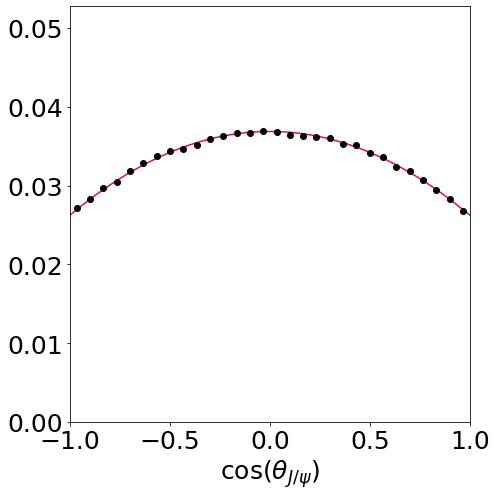

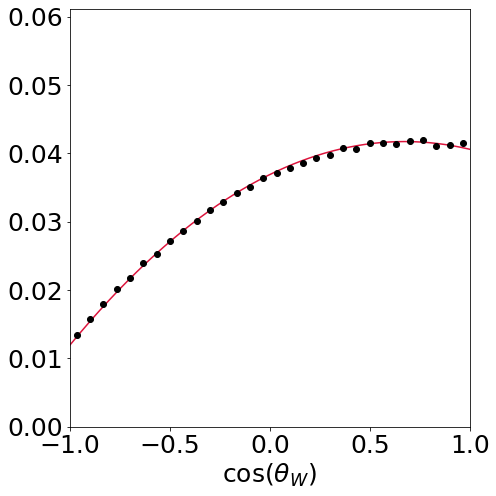

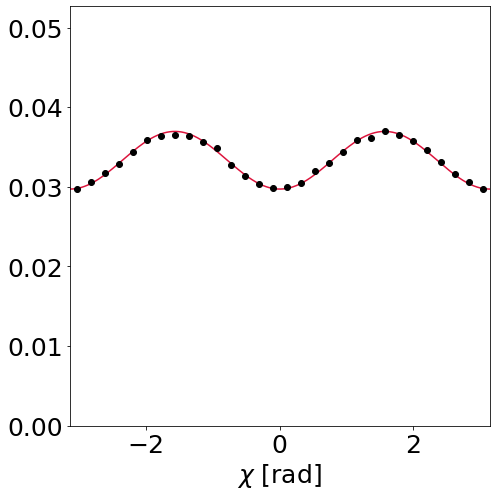

In [25]:
#Plot fit projections for each angle, to see how the fit models our MC
bins = 30
data_np = zfit.run(data)

#Loop over the fit variables
for v in obs_dict:

  fig, ax = plt.subplots(figsize=(7,7))
  lower = obs_dict[v][2]
  upper = obs_dict[v][3]
  counts, bin_edges = np.histogram(df_data[v], bins=bins, range=(lower, upper))
  bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
  err = np.sqrt(counts)
  #Normalise
  err = err / np.sum(counts)
  counts = counts / np.sum(counts)

  #Plot the data
  plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='xkcd:black')

  #Plot the PDF
  n_p = 1000
  x_plot = np.linspace(lower, upper, num=n_p)
  x_plot_data = zfit.Data.from_numpy(array=x_plot, obs=obs_dict[v][4])

  #Other dims
  other_obs = []
  for k in obs_dict:
    if(k!=v):
      other_obs.append(obs_dict[k][4])

  #Observables to integrate over
  obs_int = other_obs[0] * other_obs[1]

  #Integrating over the other dimensions
  pdf_x = custom_pdf.partial_integrate(x=x_plot_data, limits=obs_int)
  y_plot = zfit.run(pdf_x)
  #Normalise
  y_plot = y_plot / np.sum(y_plot) * (n_p/bins)

  plt.plot(x_plot, y_plot, color='crimson')

  #Labels and axis ranges
  plt.xlabel(obs_dict[v][1],fontsize=25)
  bin_width = float(upper - lower)/bins
  y_min, y_max = ax.get_ylim()
  plt.ylim(0.0,y_max*1.4)
  plt.xlim(lower, upper)
  ax.tick_params(axis='both', which='major', labelsize=25)
  plt.tight_layout()
  plt.show();
  fig.savefig(f"{ana_dir}/plots/{v}_Bc2JpsiMuNu_RapidSim_fit.pdf")


We have now performed a fit to the true angular distribution of $B_c^+ \to J/\psi \mu^+ \nu_\mu$ RapidSim MC events, to measure the underlying helicity amplitudes. The angular distributions above are perfect MC-truth, which we would be able to measure with a magic detector that could detect neutrinos and also measure all the particle 4-momenta with perfect precision. 

In reality, we cannot observe the neutrino in LHCb, which results in a loss of information and an inability to reconstruct the decay angles perfectly. In addition, we also don't measure the three muons produced in the decay with perfect precision. To understand how these issues impact our measurement, we can look at some $B_c^+ \to J/\psi \mu^+ \nu_\mu$ MC events which have passed through a simulation of the LHCb detector.